# Plot saildrone track data on satellite data

In [1]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from scipy import signal
from glob import glob
from sklearn.linear_model import LinearRegression
from matplotlib import ticker, cm
import matplotlib.colors as colors
import datetime as dt
import scipy.ndimage
import spectrum

plt.rcParams['figure.figsize'] = (10.0, 8.0)

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]




In [3]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()

    #make diruanl plot
    xlon=ds_usv.longitude.data
    time_offset_to_lmt=(xlon/360.)*24.*60
    tem = ds_usv.time+time_offset_to_lmt*np.timedelta64(1,'m')# dt.timedelta(seconds=1)
    ds_usv['tlmt']=tem
    ds_usv2= ds_usv.swap_dims({'time':'tlmt'})
    ds_usv2a = ds_usv2.where(ds_usv2.tlmt.dt.hour==6)
    dymn = ds_usv2a.groupby("tlmt.dayofyear").mean()
    ds_usv3 = ds_usv2.groupby("tlmt.dayofyear") - dymn
    ds_usv['TEMP_AIR_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_AIR_MEAN
    ds_usv['TEMP_SBE37_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_SBE37_MEAN
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)

ds_saildrone.wspd.attrs={'units':'m/s'}

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [90]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'F:/data/sat_data/smap/SSS/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [91]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    sdoy2 = str(t.timetuple().tm_yday).zfill(3)
            #\\White_home_pc\f\data\sat_data\smap\SSS\L3\RSS\V4\8day_running\SCI\2020
    fname = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem.coords['lon'] = (tem.coords['lon'] + 180) % 360 - 180
tem = tem.sortby(tem.lon)
tem = tem.sel(lon=slice(-64,-46),lat=slice(4,16))
ds_rss = tem.load()

NameError: name 'figs_dir' is not defined

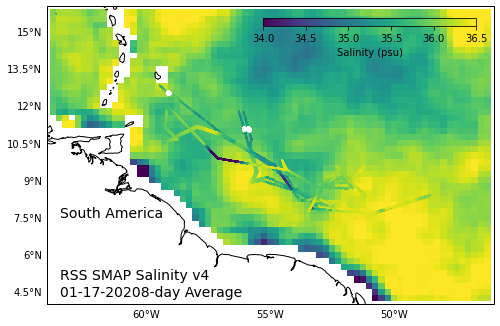

In [92]:
def map_fig(ds_sat,ds,var,text1,text2,fout,date_str):
    ds_sat = ds_sat.sel(time=date_str)
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds_sat.lon,ds_sat.lat,ds_sat[var],vmin=34,vmax=36.5,transform=ccrs.PlateCarree(),cmap='viridis')
    for i in range(3):
        ds2 = ds.isel(trajectory=i)
        ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36.5,
                      s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='viridis')
        ds2a = ds.isel(trajectory=i).sel(time=date_str)
        ax.plot(ds2a.longitude,ds2a.latitude,'.',transform=ccrs.PlateCarree(),color='w')

    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    bx1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='grey', alpha=0.5, linestyle='--')
    bx1.xlabels_top = False; bx1.ylabels_left = True
    bx1.ylabels_right = False; bx1.xlines = False
    bx1.xlocator = mticker.FixedLocator([-60,-55,-50,-45])
    bx1.xformatter = LONGITUDE_FORMATTER; bx1.yformatter = LATITUDE_FORMATTER

    #ax.legend()
    ax.text(-63.5,7.5,'South America',fontsize=14)
    ax.text(-63.5,5,text1,fontsize=14)
    ax.text(-63.5,4.3,text2,fontsize=14)
    cax = fig.add_axes([0.5, 0.8, 0.37, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('Salinity (psu)')
    fig.savefig(figs_dir+fout)     

date_start = ds.time[0]+np.timedelta64(12,'h')
date_end = ds.time[-1].data
length_cruise = int(np.floor((date_end-date_start)/np.timedelta64(1,'D')))
for incr in range(length_cruise):
    dd1 = date_start+np.timedelta64(incr,'D')
    date_str = str(dd1.data)[0:13]
    text2 = str(dd1.dt.month.data).zfill(2)+'-'+str(dd1.dt.day.data).zfill(2)+'-'+str(dd1.dt.year.data)+'8-day Average'

    #date_str = '2020-01-30T1200'
    #text2='7 Feb 2020 8-day Average'

    text1='RSS SMAP Salinity v4'
    fname = 'map_sss_smap'+date_str+'rss.png'
    map_fig(ds_rss,ds,'sss_smap',text1,text2,fname,date_str)

    text1='RSS SMAP Salinity v4 - 40 km'
    fname = 'map_sss_smap'+date_str+'_rss40km.png'
    map_fig(ds_rss,ds,'sss_smap_40km',text1,text2,fname,date_str)

    text1='JPL SMAP Salinity v4.3'
    fname = 'map_sss_smap'+date_str+'_jpl.png'
    map_fig(ds_jpl,ds,'smap_sss',text1,text2,fname,date_str)